# Classification of digits

This notebook shows how to create a neural network with Keras for classifying numbers. This material is taken from [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python). This notebook is available [here](https://gitlab.com/auraham/deep_learning_for_computer_vision/-/blob/master/notebooks/nb_cnn_mnist.ipynb).

In [2]:
from __future__ import print_function
from keras.datasets import mnist
from keras import models
from keras import layers
from keras.utils import to_categorical, plot_model
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import rcParams
from sklearn.model_selection import train_test_split
        
def print_int_matrix(vector):
    for row in vector:
        print(" ".join(["%3d" % val for val in row]))

def plot_history(history, model_name):

    # define input data
    hist_dict = history.history
    indicators = ("acc", "loss")

    # create figure
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    colors = ["#454545", "#007ca5", "#A91458"]

    x = np.arange(1, len(hist_dict["acc"])+1)

    # accuracy
    ax = axes[0]
    ax.plot(x, hist_dict["acc"], marker="o", c=colors[0], label="Acc")
    ax.plot(x, hist_dict["val_acc"], ls="--", c=colors[1], label="Val Acc")
    ax.set_title("%s Accuracy" % model_name)
    ax.set_xlabel("Epochs")
    ax.legend(loc="lower right")
    
    # plot bar
    y_a, y_b = ax.get_ylim()
    bar = np.array(hist_dict["val_acc"]).argmax() + 1 
    ax.plot([bar, bar], [y_a, y_b], c="#505050", zorder=0, lw=0.5)
    ax.set_ylim((y_a, y_b))

    # loss
    ax = axes[1]
    ax.plot(x, hist_dict["loss"], marker="o", c=colors[0], label="Loss")
    ax.plot(x, hist_dict["val_loss"], ls="--", c=colors[1], label="Val Loss")
    ax.set_title("%s Loss" % model_name)
    ax.set_xlabel("Epochs")
    ax.legend(loc="lower right")
    #bar = hist_dict["val_loss"].argmin() + 1
    #ax.plot([bar, bar], [-2, 2], c="#c0c0c0")
    
    # plot bar
    y_a, y_b = ax.get_ylim()
    bar = np.array(hist_dict["val_loss"]).argmin() + 1 
    ax.plot([bar, bar], [y_a, y_b], c="#505050", zorder=0, lw=0.5)
    ax.set_ylim((y_a, y_b))

    # adjust margins
    fig.subplots_adjust(hspace=0.4)
    
    # save figure
    fig.savefig("training_%s.jpg" % model_name, dpi=300)

## Check dataset

This block loads the dataset:

In [6]:
# load dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

`train_images` and `train_labels` comprises the training set. The model will learn from that set. On the other hand, `test_images` and `test_labels` comprises the test set. We evalute the performance of the model with the test set. Below, we display some properties of the dataset. Note that the images are encoded as Numpy `uint8` arrays:

In [4]:
print("train_images shape (%s)" % (train_images.shape,))
print("test_images shape  (%s)" % (test_images.shape,))
print("images dtype       %s\n" % train_images.dtype) 

print("train_labels shape (%s)" % (train_labels.shape,))
print("test_labels shape  (%s)" % (test_labels.shape,))
print("labels dtype       %s" % train_labels.dtype) 

train_images shape ((60000, 28, 28))
test_images shape  ((10000, 28, 28))
images dtype       uint8

train_labels shape ((60000,))
test_labels shape  ((10000,))
labels dtype       uint8


We have 60,000 training samples and 10,000 samples for testing. Notice that the data type of both patterns and labels is `uint8`. Below we inspect some examples from the dataset. It is recommeded to inspect samples from the training set only. Let's take a look at one sample:

In [5]:
sample_id = 5                               # choose a sample from training_images
sample_image = train_images[sample_id]      # shape (28, 28)
sample_label = train_labels[sample_id]      # scalar

print_int_matrix(sample_image)

  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  13  25 100 122   7   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0  33 151 208 252 252 252 146   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0  40 152 244 252 253 224 211 252 232  40   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0  15 152 239 252 252 252 216  31  37 252 252  60   0   0   0   0   0 

As it can be seen, that block roughly shows a '2'. Now, compare it with `imshow`:

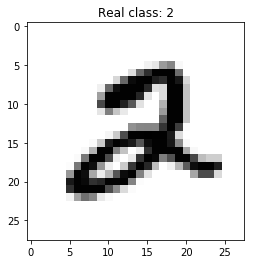

In [6]:
%matplotlib inline
sample_id = 5                               # choose a sample from trainig_images
sample_image = train_images[sample_id]      # shape (28, 28)
sample_label = train_labels[sample_id]      # scalar

plt.title("Real class: %d" % sample_label)
plt.imshow(sample_image, cmap=plt.cm.binary)
plt.show()

Let's show a few more examples:

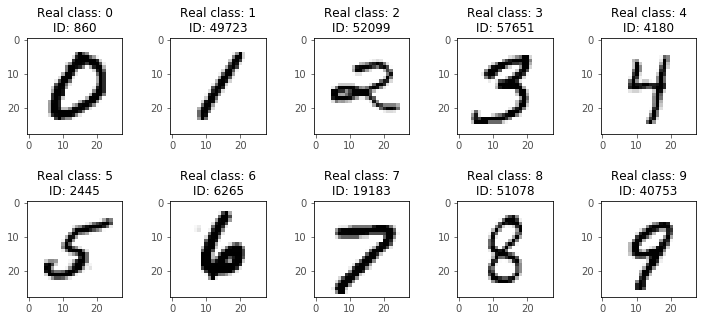

In [7]:
%matplotlib inline

# choose some ids
sample_ids = [3, 5, 5390, 5734, 6265, 53, 860, 8883, 3704, 3392]

sample_ids = [860,    # 0
              49723,  # 1
              52099,  # 2
              57651,  # 3
              4180,   # 4
              2445,   # 5
              6265,   # 6 
              19183,  # 7 
              51078,  # 8
              40753,  # 9
             ] 

# style
rcParams['xtick.color'] = "#505050"     # ticks gray color
rcParams['ytick.color'] = "#505050"     # ticks gray color

# create plot
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for ix, ax in zip(sample_ids, axes.flat):
    sample_image = train_images[ix]      # shape (28, 28)
    sample_label = train_labels[ix]      # scalar

    ax.set_title("Real class: %d\nID: %d" % (sample_label, ix))
    ax.imshow(sample_image, cmap=plt.cm.binary)

# adjust margins
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.savefig("numbers.jpg", dpi=300)

You can also use this block for displaying examples of a specific class:

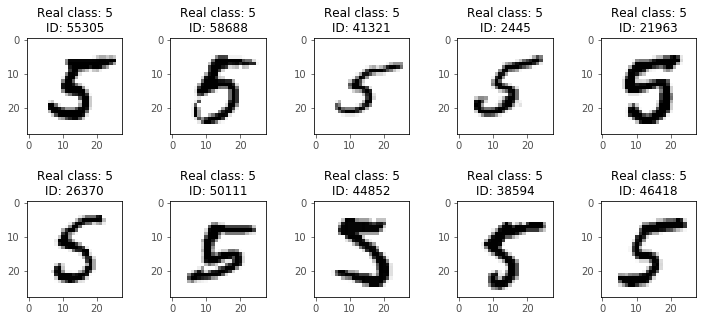

In [8]:
%matplotlib inline

# choose some ids
np.random.seed(49)
sample_ids = np.random.randint(0, len(train_images), 10)

# or...

# choose some ids of a specific class
class_ids = np.where(train_labels == 5)[0]    # choose your class here
sample_ids = np.random.choice(class_ids, 10)

# style
rcParams['xtick.color'] = "#505050"     # ticks gray color
rcParams['ytick.color'] = "#505050"     # ticks gray color

# create plot
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for ix, ax in zip(sample_ids, axes.flat):
    sample_image = train_images[ix]      # shape (28, 28)
    sample_label = train_labels[ix]      # scalar

    ax.set_title("Real class: %d\nID: %d" % (sample_label, ix))
    ax.imshow(sample_image, cmap=plt.cm.binary)

# adjust margins
fig.subplots_adjust(wspace=0.5, hspace=0.5)
#fig.savefig("numbers.jpg", dpi=300)

## Preprocessing

Before training, we need to preprocess our data as follows:

- Change data type from `uint8` to `float32`.
- Change range from `[0, 255]` to `[0, 1]`.
- Change shape from `(28, 28)` to `(784, )`.

We also need to encode the labels from integers to vectors using one-hot encoding. From Chapter 4:

> [...] you should format your data in a way that can be fed into a machine-learning model -- here, we'll assume a deep neural network:
> - Your data should be formatted as tensors
> - The values taken by these tensors should usuallu be scaled to small values: for example, in the [-1, 1] range or [0, 1] range

In [4]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# data preprocessing
X_train = X_train.reshape((60000, 28*28))
X_train = X_train.astype("float32") / 255

X_test = X_test.reshape((10000, 28*28))
X_test = X_test.astype("float32") / 255

# prepare labels (one-hot encoding)
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)

Check the change:

In [10]:
print("before preprocessing (dtype: %s,   shape: %s, min: %.2f, max: %.2f)"  % (train_images[0].dtype, train_images.shape, train_images.min(), train_images.max()))
print("after  preprocessing (dtype: %s, shape: %s,    min: %.2f, max: %.2f)" % (X_train[0].dtype,      X_train.shape,      X_train.min(),      X_train.max()))

before preprocessing (dtype: uint8,   shape: (60000, 28, 28), min: 0.00, max: 255.00)
after  preprocessing (dtype: float32, shape: (60000, 784),    min: 0.00, max: 1.00)


Notice that the **shape, range and dtype** changed. Now, each sample is a `float32` vector of shape `(784, )`.

Finally, check the labels. Notice that a label `5` is encoded as a binary vector: `[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]`:

In [11]:
print("label           ", train_labels[0])
print("encoded label   ", y_train[0])

label            5
encoded label    [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


# Create a neural network

We are ready to create our first neural network:

In [6]:
# network architecture
model = models.Sequential(name="model_v1")
model.add(layers.Dense(512, activation="relu", input_shape=(28*28, )))
model.add(layers.Dense(10, activation="softmax"))

# compilation
model.compile(optimizer="rmsprop",
                loss="categorical_crossentropy",
                metrics=["accuracy"])

We can use `summary()` to show the parameters of the model:

In [12]:
model.summary()

Model: "model_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


Also, we,can use `plot_model()` to show a graphical representation of the model:

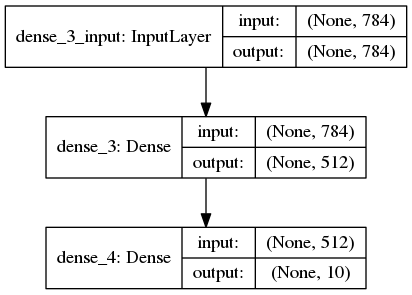

In [13]:
plot_model(model, show_shapes=True)

# Training and testing

 Before training, we split the training set into two sets: one for training and another one for validation:

In [8]:
split_X_train, split_X_val, split_y_train, split_y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In the following, we train the neural network. In order to analyze the convergence of the network, the function `fit` returns a `History` object. We use that object for creating convergence plots.

In [9]:
# trainining time: ~45s
history = model.fit(split_X_train, 
                    split_y_train, 
                    epochs=15, 
                    batch_size=128,
                    validation_data=(split_X_val, split_y_val))

W1029 00:32:27.600983 140479730497280 deprecation.py:323] From /home/auraham/.virtualenvs/keras/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1029 00:32:27.682222 140479730497280 deprecation_wrapper.py:119] From /home/auraham/.virtualenvs/keras/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 3s 64us/step - loss: 0.2708 - acc: 0.9218 - val_loss: 0.1329 - val_acc: 0.9652
Epoch 2/15
54000/54000 [==============================] - 3s 60us/step - loss: 0.1096 - acc: 0.9674 - val_loss: 0.0940 - val_acc: 0.9710
Epoch 3/15
54000/54000 [==============================] - 3s 57us/step - loss: 0.0722 - acc: 0.9785 - val_loss: 0.0928 - val_acc: 0.9702
Epoch 4/15
54000/54000 [==============================] - 3s 57us/step - loss: 0.0533 - acc: 0.9838 - val_loss: 0.0694 - val_acc: 0.9792
Epoch 5/15
54000/54000 [==============================] - 3s 57us/step - loss: 0.0400 - acc: 0.9879 - val_loss: 0.0679 - val_acc: 0.9805
Epoch 6/15
54000/54000 [==============================] - 3s 58us/step - loss: 0.0306 - acc: 0.9908 - val_loss: 0.0715 - val_acc: 0.9800
Epoch 7/15
54000/54000 [==============================] - 3s 57us/step - loss: 0.0228 - acc: 0.9933 - val_loss: 0.0718 - val_acc:

Save the model:

In [10]:
# save model
model.save("mnist_model_v1.h5")

Measure the accuracy of the model:

In [11]:
# evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test_acc:", test_acc)

10000/10000 [==============================] - 0s 38us/step
test_acc: 0.9826


In Chapter 3, the author shows how to plot the training and validation loss. In this example, we plot the training loss only becasue we did not employ a validation set. Before going any further, analyze `history` first:

In [12]:
print(history)

In [13]:
print(history.history['loss'])
print(len(history.history['loss']))

[0.2707741441064411, 0.10964332854527015, 0.07222274003205476, 0.053263502871548685, 0.04000813899989481, 0.030560228936650134, 0.02275205254016651, 0.017645124429905856, 0.013800318549076715, 0.010495158982842609, 0.00833082763750658, 0.006412921668237283, 0.0051709146183673985, 0.0038211097126412724, 0.003400846489187744]
15


In [21]:
print(history.history.keys())

dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])


`history` contains a dictionary also called `history`. As it can be seen, it contains four keys:

- `acc`, the value of the metric in the training set
- `loss`, the value of the loss function in the training set
- `val_acc`, the metric in the validation set
- `val_loss`, the value of the loss function in the validation set

Notice that each entry in that dictionary contains a list with the values of the corresponding indicator for each epoch. Let's use them to create a plot.

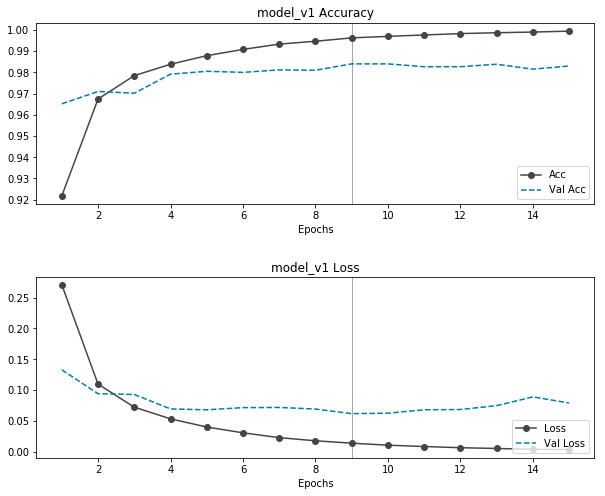

In [14]:
%matplotlib inline
plot_history(history, "model_v1")


**Note** These results may differ from yours (or even after running the same code in the same machine) because of the use of GPU. In summary, the use of GPU avoids reproducibility of results. See [this](https://stackoverflow.com/questions/50659482/why-cant-i-get-reproducible-results-in-keras-even-though-i-set-the-random-seeds) and [this](https://stackoverflow.com/questions/55200768/structuring-a-keras-project-to-achieve-reproducible-results-in-gpu/57121117#57121117) for more details.


# Demo

Now, we are ready to use the trained model for classifying samples from the testing dataset.


In [15]:
# load trained model
model = load_model("mnist_model_v1.h5")

# prediction
predictions = model.predict(X_test)

# convert to labels
y_pred = predictions.argmax(axis=1)

# compare with correct labels
y_real = test_labels          # use copy, not one-hot encoding
num_samples = len(y_real)

acc = (y_pred == y_real).sum() / num_samples
errors = y_pred != y_real

print("Accuracy: %4f" % acc)
print("# of misclassified images: %d" % errors.sum())

# indices of misclassified images
error_indices_ffnn = np.arange(num_samples, dtype=int)[errors]

Accuracy: 0.982600
# of misclassified images: 174


In [16]:
# print some of the indices of the images classified incorrectly
error_indices_ffnn[:20]

array([149, 151, 247, 274, 321, 340, 445, 495, 582, 684, 691, 717, 720,
       740, 882, 900, 947, 951, 956, 965])

Let's see some images from the training set. Remember, the model have seen these images.

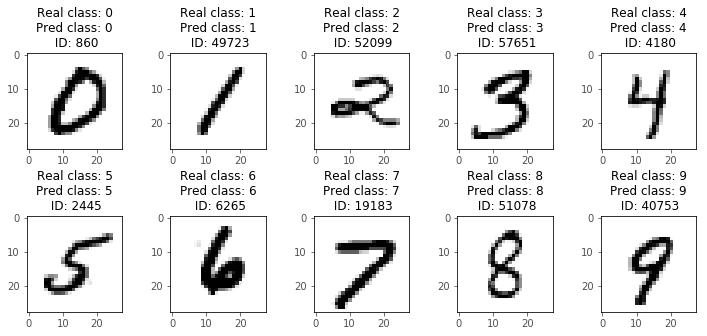

In [17]:
%matplotlib inline

# choose input images from TRAINING SET
sample_ids = [860, 49723, 52099, 57651, 4180, 2445, 6265, 19183, 51078, 40753] 

# real labels
y_real = train_labels[sample_ids]       # shape: (10, )

# predictions
predictions = model.predict(X_train[sample_ids])
y_pred = predictions.argmax(axis=1)     # shape: (10, )

# style
rcParams['xtick.color'] = "#505050"     # ticks gray color
rcParams['ytick.color'] = "#505050"     # ticks gray color

# create plot
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for ix, yreal, ypred, ax in zip(sample_ids, y_real, y_pred, axes.flat):
    sample_image = train_images[ix]      # shape (28, 28)
    color = "k" 
    if yreal != ypred: color = "r"
    
    ax.set_title("Real class: %d\nPred class: %d\n ID: %d" % (yreal, ypred, ix), color=color)
    ax.imshow(sample_image, cmap=plt.cm.binary)

# adjust margins
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.savefig("model_v1_numbers_predictions.jpg", dpi=300)

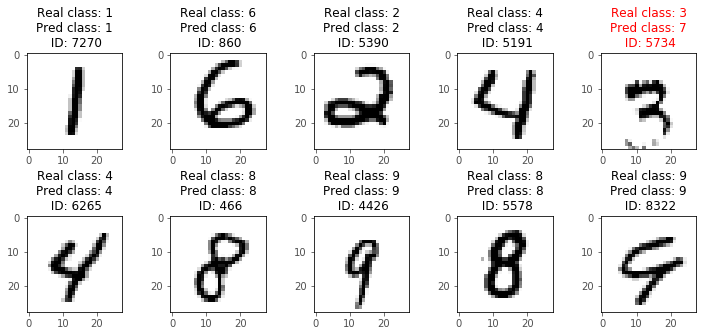

In [18]:
%matplotlib inline

# choose input images from TESTING SET
np.random.seed(42)
sample_ids = np.random.randint(0, len(test_labels), 10)

# real labels
y_real = test_labels[sample_ids]       # shape: (10, )

# predictions
predictions = model.predict(X_test[sample_ids])
y_pred = predictions.argmax(axis=1)     # shape: (10, )

# style
rcParams['xtick.color'] = "#505050"     # ticks gray color
rcParams['ytick.color'] = "#505050"     # ticks gray color

# create plot
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for ix, yreal, ypred, ax in zip(sample_ids, y_real, y_pred, axes.flat):
    sample_image = test_images[ix]      # shape (28, 28)
    color = "k" 
    if yreal != ypred: color = "r"
    
    ax.set_title("Real class: %d\nPred class: %d\n ID: %d" % (yreal, ypred, ix), color=color)
    ax.imshow(sample_image, cmap=plt.cm.binary)

# adjust margins
fig.subplots_adjust(wspace=0.5, hspace=0.5)
#fig.savefig("numbers_predictions.jpg", dpi=300)

The model misclassified more than 100 images. Let's see a few of them 

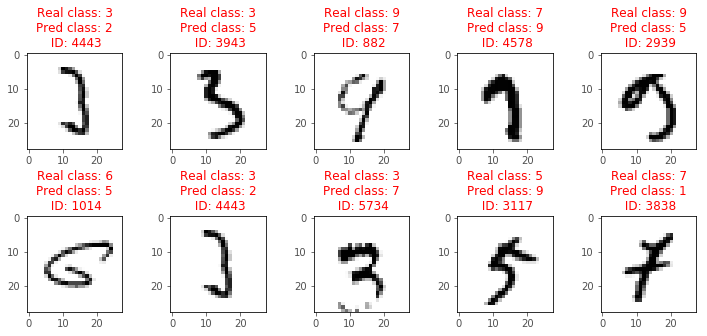

In [19]:
%matplotlib inline

# choose input images from TESTING SET
np.random.seed(42)
sample_ids = np.random.choice(error_indices_ffnn, 10)

# real labels
y_real = test_labels[sample_ids]       # shape: (10, )

# predictions
predictions = model.predict(X_test[sample_ids])
y_pred = predictions.argmax(axis=1)     # shape: (10, )

# style
rcParams['xtick.color'] = "#505050"     # ticks gray color
rcParams['ytick.color'] = "#505050"     # ticks gray color

# create plot
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for ix, yreal, ypred, ax in zip(sample_ids, y_real, y_pred, axes.flat):
    sample_image = test_images[ix]      # shape (28, 28)
    color = "k" 
    if yreal != ypred: color = "r"
    
    ax.set_title("Real class: %d\nPred class: %d\n ID: %d" % (yreal, ypred, ix), color=color)
    ax.imshow(sample_image, cmap=plt.cm.binary)

# adjust margins
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.savefig("model_v1_numbers_incorrect_predictions.jpg", dpi=300)

# Convolutional neural network

Now, we use  a Convolutional Neural Network for digit classification. Just for comparison, this is our previous architecture:


```python
# network architecture
model = models.Sequential(name="model_v1")
model.add(layers.Dense(512, activation="relu", input_shape=(28*28, )))
model.add(layers.Dense(10, activation="softmax"))

# compilation
model.compile(optimizer="rmsprop",
                loss="categorical_crossentropy",
                metrics=["accuracy"])
```

In [21]:
# network architecture
model = models.Sequential(name="model_v2")

# feature extractor
model.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation="relu"))

# classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

# compilation
model.compile(optimizer="rmsprop",
                loss="categorical_crossentropy",
                metrics=["accuracy"],                
                )

In [22]:
model.summary()

Model: "model_v2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                369

In [23]:
plot_model(model, show_shapes=True)

In [24]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# data preprocessing
X_train = X_train.reshape((60000, 28, 28, 1))    # use (28, 28, 1), not (28*28, )
X_train = X_train.astype("float32") / 255

X_test = X_test.reshape((10000, 28, 28, 1))      # use (28, 28, 1), not (28*28, )
X_test = X_test.astype("float32") / 255

# prepare labels (one-hot encoding)
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)

# split into training and validation
split_X_train, split_X_val, split_y_train, split_y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# add callback
callback_list = [
    ModelCheckpoint(                         # saves the current weights after every epoch
        verbose=1,                           # verbosity mode
        filepath="model_v2_{epoch:02d}.h5",  # path to the destination model file
        monitor="val_loss",                  # if the validation loss is improved,
        save_best_only=True,                 # saves (overwrites) the best model so far 
    )
]

# trainining time: ~45s
history = model.fit(split_X_train, 
                    split_y_train, 
                    epochs=15,
                    callbacks=callback_list,
                    batch_size=128,
                    validation_data=(split_X_val, split_y_val))

# save model
model.save("mnist_model_v2.h5")

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 21s 397us/step - loss: 0.2513 - acc: 0.9204 - val_loss: 0.1022 - val_acc: 0.9685

Epoch 00001: val_loss improved from inf to 0.10225, saving model to model_v2_01.h5
Epoch 2/15
54000/54000 [==============================] - 21s 389us/step - loss: 0.0586 - acc: 0.9821 - val_loss: 0.0512 - val_acc: 0.9858

Epoch 00002: val_loss improved from 0.10225 to 0.05123, saving model to model_v2_02.h5
Epoch 3/15
54000/54000 [==============================] - 21s 393us/step - loss: 0.0392 - acc: 0.9873 - val_loss: 0.0463 - val_acc: 0.9842

Epoch 00003: val_loss improved from 0.05123 to 0.04634, saving model to model_v2_03.h5
Epoch 4/15
54000/54000 [==============================] - 23s 418us/step - loss: 0.0299 - acc: 0.9909 - val_loss: 0.0490 - val_acc: 0.9852

Epoch 00004: val_loss did not improve from 0.04634
Epoch 5/15
54000/54000 [==============================] - 22s 414us/step - loss: 0.

In [25]:
# save model
model.save("mnist_model_v2.h5")

In [26]:
# evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test_acc:", test_acc)

10000/10000 [==============================] - 1s 129us/step
test_acc: 0.9924


In [28]:
%matplotlib inline
plot_history(history, "model_v2")

Let's find how many images were classified incorrectly:

In [62]:
# load trained model
model = load_model("model_v2_07.h5")  # you may need to change this line

# prediction
predictions = model.predict(X_test)

# convert to labels
y_pred = predictions.argmax(axis=1)

# compare with correct labels
y_real = test_labels                 # use copy, not one-hot encoding
num_samples = len(y_real)

acc = (y_pred == y_real).sum() / num_samples
errors = y_pred != y_real

print("Accuracy: %4f" % acc)
print("# of misclassified images: %d" % errors.sum())

# indices of misclassified images
error_indices_cnn_v2 = np.arange(num_samples, dtype=int)[errors]

Accuracy: 0.993600
# of misclassified images: 64


We use the model v2 to classify some of the images incorrectly classified by the model v1:

In [65]:
%matplotlib inline

# load model
model = load_model("model_v2_07.h5")    # you may need to change this line

# choose input images from TESTING SET
np.random.seed(42)
sample_ids = np.random.choice(error_indices_ffnn, 10)

# real labels
y_real = test_labels[sample_ids]        # shape: (10, )

# predictions
predictions = model.predict(X_test[sample_ids])
y_pred = predictions.argmax(axis=1)     # shape: (10, )

# style
rcParams['xtick.color'] = "#505050"     # ticks gray color
rcParams['ytick.color'] = "#505050"     # ticks gray color

# create plot
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for ix, yreal, ypred, ax in zip(sample_ids, y_real, y_pred, axes.flat):
    sample_image = test_images[ix]      # shape (28, 28)
    color = "k" 
    if yreal != ypred: color = "r"
    
    ax.set_title("Real class: %d\nPred class: %d\n ID: %d" % (yreal, ypred, ix), color=color)
    ax.imshow(sample_image, cmap=plt.cm.binary)

# adjust margins
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.savefig("numbers_predictions_v2.jpg", dpi=300)

Finally, let's see some of the images incorrectly classified by the model v2:

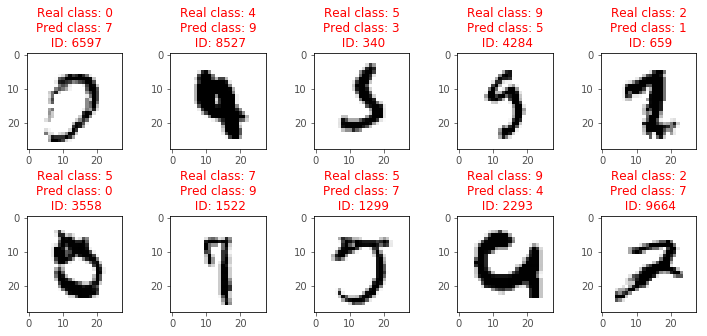

In [66]:
%matplotlib inline

# load model
model = load_model("model_v2_07.h5")    # you may need to change this line

# choose input images from TESTING SET
np.random.seed(42)
sample_ids = np.random.choice(error_indices_cnn_v2, 10, replace=False)

# real labels
y_real = test_labels[sample_ids]        # shape: (10, )

# predictions
predictions = model.predict(X_test[sample_ids])
y_pred = predictions.argmax(axis=1)     # shape: (10, )

# style
rcParams['xtick.color'] = "#505050"     # ticks gray color
rcParams['ytick.color'] = "#505050"     # ticks gray color

# create plot
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for ix, yreal, ypred, ax in zip(sample_ids, y_real, y_pred, axes.flat):
    sample_image = test_images[ix]      # shape (28, 28)
    color = "k" 
    if yreal != ypred: color = "r"
    
    ax.set_title("Real class: %d\nPred class: %d\n ID: %d" % (yreal, ypred, ix), color=color)
    ax.imshow(sample_image, cmap=plt.cm.binary)

# adjust margins
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.savefig("numbers_incorrect_predictions_v2.jpg", dpi=300)

# Data Augmentation

In this section, we use the architecture described in [this notebook from Kaggle](https://www.kaggle.com/elcaiseri/mnist-simple-cnn-keras-accuracy-0-99-top-1). It turns out that we can improve our ~99% by using:
  - A validation test
  - A deeper model
  - A technique called data augmentation. 

Let's use the same model along with data augmentation. First, let's preprocess and split the dataset:

In [7]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# data preprocessing
X_train = X_train.reshape((60000, 28, 28, 1))    # use (28, 28, 1), not (28*28, )
X_train = X_train.astype("float32") / 255

X_test = X_test.reshape((10000, 28, 28, 1))      # use (28, 28, 1), not (28*28, )
X_test = X_test.astype("float32") / 255

# prepare labels (one-hot encoding)
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)

# split into training and validation
split_X_train, split_X_val, split_y_train, split_y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

Create a generator to use data augmentation:

In [37]:
datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=10,                    # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                     # randomly zoom image 
        width_shift_range=0.1,                # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,               # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,                # randomly flip images
        vertical_flip=False)                  # randomly flip images

train_gen = datagen.flow(split_X_train, split_y_train, batch_size=64)
val_gen = datagen.flow(split_X_val, split_y_val, batch_size=64)

We can use the generators for iterating over the dataset as follows. **Note** Be aware of using a `break` statement to stop the loop.

In [38]:
for batch, labels in train_gen:
    print(batch.shape)
    print(labels.shape)
    break

(64, 28, 28, 1)
(64, 10)


Remember that our model expects an image of shape `(28, 28, 1)`. We need to add a fourth dimension:

In [39]:
sample_ids = [860, 49723, 52099, 57651, 4180, 2445, 6265, 19183, 51078, 40753]  # one example per class
sample_X = train_images[sample_ids]
print(sample_X.shape)

(10, 28, 28)


You can use `expand_dims` for adding the last dimension:

In [40]:
np.expand_dims(sample_X, axis=3).shape

(10, 28, 28, 1)

Now, we are ready for plotting a few images. Remember, we are using data augmentation. Thus, the following images are *new* for the model.

In [50]:
input_set = np.expand_dims(sample_X, axis=3)         # use all 10 digits
input_set = np.expand_dims(sample_X[[0]], axis=3)    # or use a single image from sample_X, like 0 in this case, 
                                                     # to show the transformations made in a single digit
# style
rcParams['xtick.color'] = "#505050"     # ticks gray color
rcParams['ytick.color'] = "#505050"     # ticks gray color

# create plot
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()
    
i = 0
for batch in datagen.flow(input_set, batch_size=1):
    
    image = batch[0, :, :, 0]  # shape: (28, 28)
    axes[i].imshow(image, cmap=plt.cm.binary)
    i+=1
    
    if i % 10 == 0:
        break

# adjust margins
fig.subplots_adjust(wspace=0.5, hspace=0.5)
#fig.savefig("numbers_predictions.jpg", dpi=300)

Let's train a new model using data augmentation:

In [51]:
# network architecture
model = models.Sequential(name="model_v3")

# feature extractor
model.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation="relu"))

# classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

# compilation
model.compile(optimizer="rmsprop",
                loss="categorical_crossentropy",
                metrics=["accuracy"],                
                )
# add callback
callback_list = [
    ModelCheckpoint(                         # saves the current weights after every epoch
        verbose=1,                           # verbosity mode
        filepath="model_v3_{epoch:02d}.h5",  # path to the destination model file
        monitor="val_loss",                  # if the validation loss is improved,
        save_best_only=True,                 # saves (overwrites) the best model so far 
    )
]

# training
batch_size = 64
history = model.fit_generator(train_gen, 
                              epochs = 15, 
                              steps_per_epoch = split_X_train.shape[0] // batch_size,
                              validation_data = val_gen,
                              validation_steps = split_X_val.shape[0] // batch_size,
                              callbacks=callback_list
                             )

# save model
model.save("mnist_model_v3.h5")

Epoch 1/15
843/843 [==============================] - 29s 35ms/step - loss: 0.3731 - acc: 0.8804 - val_loss: 0.1122 - val_acc: 0.9672

Epoch 00001: val_loss improved from inf to 0.11224, saving model to model_v3_01.h5
Epoch 2/15
843/843 [==============================] - 29s 34ms/step - loss: 0.1142 - acc: 0.9644 - val_loss: 0.0840 - val_acc: 0.9724

Epoch 00002: val_loss improved from 0.11224 to 0.08395, saving model to model_v3_02.h5
Epoch 3/15
843/843 [==============================] - 29s 35ms/step - loss: 0.0800 - acc: 0.9751 - val_loss: 0.0581 - val_acc: 0.9816

Epoch 00003: val_loss improved from 0.08395 to 0.05811, saving model to model_v3_03.h5
Epoch 4/15
843/843 [==============================] - 30s 35ms/step - loss: 0.0637 - acc: 0.9804 - val_loss: 0.0508 - val_acc: 0.9847

Epoch 00004: val_loss improved from 0.05811 to 0.05081, saving model to model_v3_04.h5
Epoch 5/15
843/843 [==============================] - 30s 35ms/step - loss: 0.0549 - acc: 0.9835 - val_loss: 0.0594 

In [52]:
# evalute performance
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test acc:", test_acc)

10000/10000 [==============================] - 1s 136us/step
test acc: 0.9896


In [53]:
%matplotlib inline
plot_history(history, "model_v3")

Let's find how many images were classified incorrectly:

In [54]:
# load trained model
model = load_model("model_v3_07.h5")  # you may need to change this line

# prediction
predictions = model.predict(X_test)

# convert to labels
y_pred = predictions.argmax(axis=1)

# compare with correct labels
y_real = test_labels                 # use copy, not one-hot encoding
num_samples = len(y_real)

acc = (y_pred == y_real).sum() / num_samples
errors = y_pred != y_real

print("Accuracy: %4f" % acc)
print("# of misclassified images: %d" % errors.sum())

# indices of misclassified images
error_indices_cnn = np.arange(num_samples, dtype=int)[errors]

Accuracy: 0.992800
# of misclassified images: 72


It seems that the model is a bit overfitted since it classified incorrectly more images than the previous model:

```
Accuracy: 0.993600
# of misclassified images: 64
```

## Dropout

In this section, we add a dropout layer to avoid overfitting.

In [55]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# data preprocessing
X_train = X_train.reshape((60000, 28, 28, 1))    # use (28, 28, 1), not (28*28, )
X_train = X_train.astype("float32") / 255

X_test = X_test.reshape((10000, 28, 28, 1))      # use (28, 28, 1), not (28*28, )
X_test = X_test.astype("float32") / 255

# prepare labels (one-hot encoding)
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)

# split into training and validation
split_X_train, split_X_val, split_y_train, split_y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [56]:
# create generator
datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=10,                    # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                     # randomly zoom image 
        width_shift_range=0.1,                # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,               # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,                # randomly flip images
        vertical_flip=False)                  # randomly flip images

train_gen = datagen.flow(split_X_train, split_y_train, batch_size=64)
val_gen = datagen.flow(split_X_val, split_y_val, batch_size=64)

We add a dropout layer after flattening features:

In [57]:
# network architecture
model = models.Sequential(name="model_v4")

# feature extractor
model.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation="relu"))

# classifier
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))             # dropout layer
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

# compilation
model.compile(optimizer="rmsprop",
                loss="categorical_crossentropy",
                metrics=["accuracy"],                
                )
# add callback
callback_list = [
    ModelCheckpoint(                         # saves the current weights after every epoch
        verbose=1,                           # verbosity mode
        filepath="model_v4_{epoch:02d}.h5",  # path to the destination model file
        monitor="val_loss",                  # if the validation loss is improved,
        save_best_only=True,                 # saves (overwrites) the best model so far 
    )
]

# training
batch_size = 64
history = model.fit_generator(train_gen, 
                              epochs = 15, 
                              steps_per_epoch = split_X_train.shape[0] // batch_size,
                              validation_data = val_gen,
                              validation_steps = split_X_val.shape[0] // batch_size,
                              callbacks=callback_list
                             )

# save model
model.save("mnist_model_v4.h5")

W1029 01:07:47.925176 140479730497280 deprecation.py:506] From /home/auraham/.virtualenvs/keras/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Epoch 1/15
843/843 [==============================] - 30s 36ms/step - loss: 0.4957 - acc: 0.8396 - val_loss: 0.2520 - val_acc: 0.9231

Epoch 00001: val_loss improved from inf to 0.25196, saving model to model_v4_01.h5
Epoch 2/15
843/843 [==============================] - 29s 35ms/step - loss: 0.1674 - acc: 0.9487 - val_loss: 0.0833 - val_acc: 0.9730

Epoch 00002: val_loss improved from 0.25196 to 0.08325, saving model to model_v4_02.h5
Epoch 3/15
843/843 [==============================] - 30s 35ms/step - loss: 0.1145 - acc: 0.9652 - val_loss: 0.0881 - val_acc: 0.9744

Epoch 00003: val_loss did not improve from 0.08325
Epoch 4/15
843/843 [==============================] - 30s 36ms/step - loss: 0.0939 - acc: 0.9708 - val_loss: 0.0688 - val_acc: 0.9788

Epoch 00004: val_loss improved from 0.08325 to 0.06881, saving model to model_v4_04.h5
Epoch 5/15
843/843 [==============================] - 30s 36ms/step - loss: 0.0842 - acc: 0.9745 - val_loss: 0.0554 - val_acc: 0.9847

Epoch 00005: val_

In [58]:
# evalute performance
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test acc:", test_acc)

10000/10000 [==============================] - 1s 138us/step
test acc: 0.992


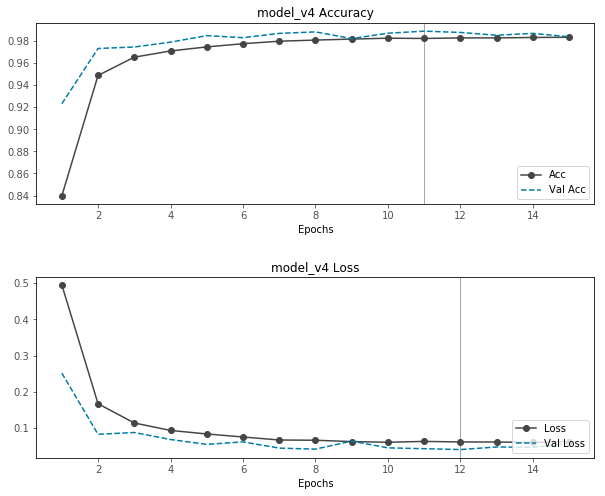

In [59]:
%matplotlib inline
plot_history(history, "model_v4")

In [8]:
# load trained model
model = load_model("model_v4_12.h5")  # you may need to change this line

# prediction
predictions = model.predict(X_test)

# convert to labels
y_pred = predictions.argmax(axis=1)

# compare with correct labels
y_real = test_labels                 # use copy, not one-hot encoding
num_samples = len(y_real)

acc = (y_pred == y_real).sum() / num_samples
errors = y_pred != y_real

print("Accuracy: %4f" % acc)
print("# of misclassified images: %d" % errors.sum())

# indices of misclassified images
error_indices_cnn_v4 = np.arange(num_samples, dtype=int)[errors]

Accuracy: 0.994100
# of misclassified images: 59


This is an improvement! Our previous model classified incorrectly 64 images. Let's see some of the images classified incorrectly by this new model:

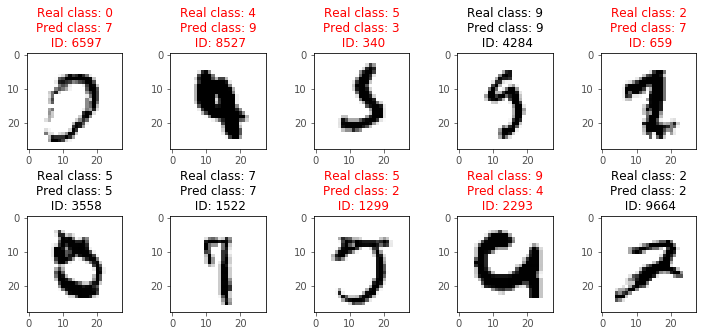

In [68]:
%matplotlib inline

# load model
model = load_model("model_v4_12.h5")    # you may need to change this line

# choose input images from TESTING SET
np.random.seed(42)
sample_ids = np.random.choice(error_indices_cnn_v2, 10, replace=False)  # errors of model v2

# real labels
y_real = test_labels[sample_ids]        # shape: (10, )

# predictions
predictions = model.predict(X_test[sample_ids])
y_pred = predictions.argmax(axis=1)     # shape: (10, )

# style
rcParams['xtick.color'] = "#505050"     # ticks gray color
rcParams['ytick.color'] = "#505050"     # ticks gray color

# create plot
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for ix, yreal, ypred, ax in zip(sample_ids, y_real, y_pred, axes.flat):
    sample_image = test_images[ix]      # shape (28, 28)
    color = "k" 
    if yreal != ypred: color = "r"
    
    ax.set_title("Real class: %d\nPred class: %d\n ID: %d" % (yreal, ypred, ix), color=color)
    ax.imshow(sample_image, cmap=plt.cm.binary)

# adjust margins
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.savefig("numbers_predictions_v4.jpg", dpi=300)

Now, let's see some of the most challenging images for this model:

In [71]:
%matplotlib inline

# load model
model = load_model("model_v4_12.h5")    # you may need to change this line

# choose input images from TESTING SET
np.random.seed(42)
sample_ids = np.random.choice(error_indices_cnn_v4, 10, replace=False)  # errors of model v4

# real labels
y_real = test_labels[sample_ids]        # shape: (10, )

# predictions
predictions = model.predict(X_test[sample_ids])
y_pred = predictions.argmax(axis=1)     # shape: (10, )

# style
rcParams['xtick.color'] = "#505050"     # ticks gray color
rcParams['ytick.color'] = "#505050"     # ticks gray color

# create plot
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for ix, yreal, ypred, ax in zip(sample_ids, y_real, y_pred, axes.flat):
    sample_image = test_images[ix]      # shape (28, 28)
    color = "k" 
    if yreal != ypred: color = "r"
    
    ax.set_title("Real class: %d\nPred class: %d\n ID: %d" % (yreal, ypred, ix), color=color)
    ax.imshow(sample_image, cmap=plt.cm.binary)

# adjust margins
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.savefig("numbers_incorrect_predictions_v4.jpg", dpi=300)

## Adding more filters

In this section, we change the model by adding more filters.

In [6]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# data preprocessing
X_train = X_train.reshape((60000, 28, 28, 1))    # use (28, 28, 1), not (28*28, )
X_train = X_train.astype("float32") / 255

X_test = X_test.reshape((10000, 28, 28, 1))      # use (28, 28, 1), not (28*28, )
X_test = X_test.astype("float32") / 255

# prepare labels (one-hot encoding)
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)

# split into training and validation
split_X_train, split_X_val, split_y_train, split_y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [76]:
# create generator
datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=10,                    # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                     # randomly zoom image 
        width_shift_range=0.1,                # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,               # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,                # randomly flip images
        vertical_flip=False)                  # randomly flip images

train_gen = datagen.flow(split_X_train, split_y_train, batch_size=64)
val_gen = datagen.flow(split_X_val, split_y_val, batch_size=64)

Here, we add more convolutional layers:


```python
# network architecture
model = models.Sequential(name="model_v4")

# feature extractor
model.add(layers.Conv2D(64, (3,3), activation="relu", input_shape=(28, 28, 1)))
model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))

# classifier
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

# compilation
model.compile(optimizer="rmsprop",                       # the author employed 'adam'; we use 'rmsprop' for a fair comparison
                loss="categorical_crossentropy",
                metrics=["accuracy"])
```


In [84]:
# network architecture
model = models.Sequential(name="model_v5")

# feature extractor
model.add(layers.Conv2D(64, (3,3), activation="relu", input_shape=(28, 28, 1)))
model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))                    

# classifier
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.5))             # dropout layer
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

# compilation
model.compile(optimizer="rmsprop",
                loss="categorical_crossentropy",
                metrics=["accuracy"],                
                )
# add callback
callback_list = [
    ModelCheckpoint(                         # saves the current weights after every epoch
        verbose=1,                           # verbosity mode
        filepath="model_v5_{epoch:02d}.h5",  # path to the destination model file
        monitor="val_loss",                  # if the validation loss is improved,
        save_best_only=True,                 # saves (overwrites) the best model so far 
    )
]

# training
batch_size = 64
history = model.fit_generator(train_gen, 
                              epochs = 15, 
                              steps_per_epoch = split_X_train.shape[0] // batch_size,
                              validation_data = val_gen,
                              validation_steps = split_X_val.shape[0] // batch_size,
                              callbacks=callback_list
                             )

# save model
model.save("mnist_model_v5.h5")

W1029 02:23:43.235940 140479730497280 deprecation_wrapper.py:119] From /home/auraham/.virtualenvs/keras/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



Epoch 1/15
843/843 [==============================] - 201s 239ms/step - loss: 0.1498 - acc: 0.9540 - val_loss: 0.0976 - val_acc: 0.9755

Epoch 00001: val_loss improved from inf to 0.09759, saving model to model_v5_01.h5
Epoch 2/15
843/843 [==============================] - 201s 238ms/step - loss: 0.0708 - acc: 0.9801 - val_loss: 0.0561 - val_acc: 0.9847

Epoch 00002: val_loss improved from 0.09759 to 0.05606, saving model to model_v5_02.h5
Epoch 3/15
843/843 [==============================] - 201s 239ms/step - loss: 0.0544 - acc: 0.9847 - val_loss: 0.0682 - val_acc: 0.9847

Epoch 00003: val_loss did not improve from 0.05606
Epoch 4/15
843/843 [==============================] - 200s 237ms/step - loss: 0.0487 - acc: 0.9868 - val_loss: 0.0774 - val_acc: 0.9828

Epoch 00004: val_loss did not improve from 0.05606
Epoch 5/15
843/843 [==============================] - 200s 238ms/step - loss: 0.0463 - acc: 0.9875 - val_loss: 0.0472 - val_acc: 0.9907

Epoch 00005: val_loss improved from 0.05606

In [85]:
# evalute performance
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test acc:", test_acc)

10000/10000 [==============================] - 8s 810us/step
test acc: 0.9908


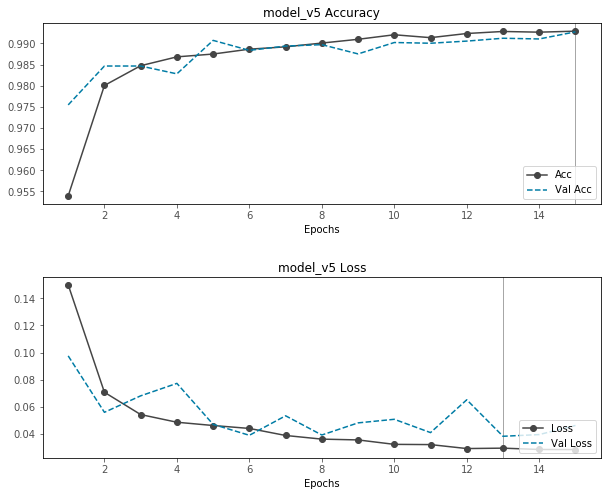

In [86]:
%matplotlib inline
plot_history(history, "model_v5")

In [34]:
# load trained model
model = load_model("model_v5_13.h5")  # you may need to change this line

# prediction
predictions = model.predict(X_test)

# convert to labels
y_pred = predictions.argmax(axis=1)

# compare with correct labels
y_real = test_labels                 # use copy, not one-hot encoding
num_samples = len(y_real)

acc = (y_pred == y_real).sum() / num_samples
errors = y_pred != y_real

print("Accuracy: %4f" % acc)
print("# of misclassified images: %d" % errors.sum())

# indices of misclassified images
error_indices_cnn_v5 = np.arange(num_samples, dtype=int)[errors]

Accuracy: 0.994100
# of misclassified images: 59


This is interesting, both models, v4 and v5, classified incorrectly the same number of images.

In [13]:
%matplotlib inline

# load model
model = load_model("model_v5_13.h5")    # you may need to change this line

# choose input images from TESTING SET
np.random.seed(42)
sample_ids = np.random.choice(error_indices_cnn_v4, 10, replace=False)  # errors of model v2

# real labels
y_real = test_labels[sample_ids]        # shape: (10, )

# predictions
predictions = model.predict(X_test[sample_ids])
y_pred = predictions.argmax(axis=1)     # shape: (10, )

# style
rcParams['xtick.color'] = "#505050"     # ticks gray color
rcParams['ytick.color'] = "#505050"     # ticks gray color

# create plot
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for ix, yreal, ypred, ax in zip(sample_ids, y_real, y_pred, axes.flat):
    sample_image = test_images[ix]      # shape (28, 28)
    color = "k" 
    if yreal != ypred: color = "r"
    
    ax.set_title("Real class: %d\nPred class: %d\n ID: %d" % (yreal, ypred, ix), color=color)
    ax.imshow(sample_image, cmap=plt.cm.binary)

# adjust margins
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.savefig("numbers_predictions_v5.jpg", dpi=300)

It seems that the model v5 can classify some of the images incorrectly classified by the model v4. That is, both models fail to identify about the same number of images (59), but the images themsleves are different. Let's see some of the challenging images for model v5:

In [14]:
%matplotlib inline

# load model
model = load_model("model_v5_13.h5")    # you may need to change this line

# choose input images from TESTING SET
np.random.seed(42)
sample_ids = np.random.choice(error_indices_cnn_v5, 10, replace=False)  # errors of model v5

# real labels
y_real = test_labels[sample_ids]        # shape: (10, )

# predictions
predictions = model.predict(X_test[sample_ids])
y_pred = predictions.argmax(axis=1)     # shape: (10, )

# style
rcParams['xtick.color'] = "#505050"     # ticks gray color
rcParams['ytick.color'] = "#505050"     # ticks gray color

# create plot
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for ix, yreal, ypred, ax in zip(sample_ids, y_real, y_pred, axes.flat):
    sample_image = test_images[ix]      # shape (28, 28)
    color = "k" 
    if yreal != ypred: color = "r"
    
    ax.set_title("Real class: %d\nPred class: %d\n ID: %d" % (yreal, ypred, ix), color=color)
    ax.imshow(sample_image, cmap=plt.cm.binary)

# adjust margins
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.savefig("numbers_incorrect_predictions_v5.jpg", dpi=300)

In [15]:
error_indices_cnn_v4

array([ 151,  340,  359,  583,  625,  659,  674,  716,  947, 1182, 1247,
       1299, 1393, 1425, 1621, 1709, 1868, 1901, 2035, 2130, 2182, 2293,
       2343, 2454, 2462, 2597, 2654, 2927, 2939, 3060, 3073, 3422, 3475,
       3767, 3869, 4176, 4201, 4497, 4536, 4740, 4761, 5654, 5937, 5955,
       6166, 6571, 6576, 6597, 6625, 8246, 8275, 8316, 8382, 8527, 9009,
       9638, 9642, 9679, 9729])

In [16]:
error_indices_cnn_v5

array([ 115,  445,  582,  625,  659,  716,  947, 1014, 1061, 1242, 1247,
       1260, 1438, 1459, 1790, 1847, 1878, 1901, 1941, 2035, 2040, 2130,
       2447, 2454, 2462, 2597, 2771, 3073, 3225, 3422, 3767, 4027, 4176,
       4507, 4699, 4723, 4783, 4860, 4911, 5165, 5654, 5955, 6558, 6576,
       6597, 6625, 6847, 7434, 8316, 8325, 8382, 8527, 9669, 9679, 9693,
       9729, 9754, 9850, 9922])

## Combining predictions

Let's use both models, v4 and v5, for prediction. We are going to sum the predictions of both models in a single matrix. Remember, both models return a 10-dimensional vector with probabilities, one for each class:

```
prediction_v4 = [0.0000 0.0000 0.0000 0.1804 0.0000 0.0006 0.0000 0.0000 0.5270 0.2920]
prediction_v5 = [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000]
```

Then, we add both vectors and take the maximum argument:

```
model_v4 - class: 8, probs: [0.0000 0.0000 0.0000 0.1804 0.0000 0.0006 0.0000 0.0000 0.5270 0.2920]
model_v5 - class: 9, probs: [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000]
merge    - class: 9, probs: [0.0000 0.0000 0.0000 0.1804 0.0000 0.0006 0.0000 0.0000 0.5270 1.2920]
```

Let's load both models:

In [4]:
# load model
model_v4 = load_model("model_v4_12.h5")    # you may need to change this line
model_v5 = load_model("model_v5_13.h5")    # you may need to change this line

Below, we classify challenging images for the model v4:

In [9]:
# images classified incorrectly by model v4
y_real = test_labels[error_indices_cnn_v4]
predictions_v4 = model_v4.predict(X_test[error_indices_cnn_v4]) 
predictions_v5 = model_v5.predict(X_test[error_indices_cnn_v4])

In [10]:
print(predictions_v4.argmax(axis=1))

[8 3 4 7 4 7 3 7 9 5 5 2 3 6 6 5 4 4 3 9 2 4 7 5 0 3 1 7 5 7 2 0 7 2 4 7 7
 7 5 5 4 2 3 8 8 7 1 7 2 5 6 2 2 9 2 7 7 2 6]


In [11]:
print(predictions_v5.argmax(axis=1))

[9 5 9 2 4 7 5 7 9 6 5 5 5 8 0 9 1 4 3 9 1 9 1 0 0 3 6 3 9 9 2 0 3 2 9 7 1
 8 6 3 9 2 5 8 9 9 1 7 7 3 5 2 2 9 7 9 9 2 6]


Now, we aggregate both predictions:

In [12]:
predictions = predictions_v4 + predictions_v5

In [13]:
y_pred = predictions.argmax(axis=1)

The number of images classified incorrectly is 28:

In [14]:
# real labels
(y_real != y_pred).sum()

28

Below, we print the output of both models for a single example: 

In [30]:
def print_prediction(pred, model):
    probs = "[" + " ".join(["%.4f" % val for val in pred]) + "]"
    pclass = pred.argmax()
    print("%10s - class: %d, probs: %s" % (model, pclass, probs))

In [31]:
# first prediction of both models
pred_v4 = predictions_v4[0]
prev_v5 = predictions_v5[0]

print_prediction(pred_v4, "model_v4")
print_prediction(pred_v5, "model_v5")

# merge predictions
print_prediction(pred_v4 + pred_v5, "merge")

  model_v4 - class: 8, probs: [0.0000 0.0000 0.0000 0.1804 0.0000 0.0006 0.0000 0.0000 0.5270 0.2920]
  model_v5 - class: 9, probs: [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000]
     merge - class: 9, probs: [0.0000 0.0000 0.0000 0.1804 0.0000 0.0006 0.0000 0.0000 0.5270 1.2920]


As it can be seen, model v4 predicts '8' whereas model v5 predicts '9'. When both vectors are aggregated, the element corresponding to the class '9' is the highest in the vector. Therefore, the prediction by using both models is '9'.

Let's try our new model with the images classified incorrectly by model v4. 

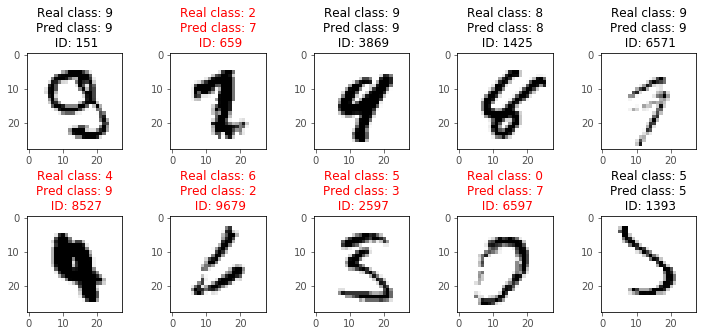

In [42]:
%matplotlib inline

# load model
model_v4 = load_model("model_v4_12.h5")    # you may need to change this line
model_v5 = load_model("model_v5_13.h5")    # you may need to change this line

# choose input images from TESTING SET
np.random.seed(42)
sample_ids = np.random.choice(error_indices_cnn_v4, 10, replace=False)  # errors of model v4

# real labels
y_real = test_labels[sample_ids]        # shape: (10, )

# predictions from both models
predictions_v4 = model_v4.predict(X_test[sample_ids])
predictions_v5 = model_v5.predict(X_test[sample_ids])

# merge predictions
predictions = predictions_v4 + predictions_v5
y_pred = predictions.argmax(axis=1)     # shape: (10, )

# style
rcParams['xtick.color'] = "#505050"     # ticks gray color
rcParams['ytick.color'] = "#505050"     # ticks gray color

# create plot
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for ix, yreal, ypred, ax in zip(sample_ids, y_real, y_pred, axes.flat):
    sample_image = test_images[ix]      # shape (28, 28)
    color = "k" 
    if yreal != ypred: color = "r"
    
    ax.set_title("Real class: %d\nPred class: %d\n ID: %d" % (yreal, ypred, ix), color=color)
    ax.imshow(sample_image, cmap=plt.cm.binary)

# adjust margins
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.savefig("numbers_incorrect_predictions_merge_v4.jpg", dpi=300)

Now, we use our new model with the images classified incorrectly by model v5. 

In [46]:
%matplotlib inline

# load model
model_v4 = load_model("model_v4_12.h5")    # you may need to change this line
model_v5 = load_model("model_v5_13.h5")    # you may need to change this line

# choose input images from TESTING SET
np.random.seed(42)
sample_ids = np.random.choice(error_indices_cnn_v5, 10, replace=False)  # errors of model v5

# real labels
y_real = test_labels[sample_ids]        # shape: (10, )

# predictions from both models
predictions_v4 = model_v4.predict(X_test[sample_ids])
predictions_v5 = model_v5.predict(X_test[sample_ids])

# merge predictions
predictions = predictions_v4 + predictions_v5
y_pred = predictions.argmax(axis=1)     # shape: (10, )

# style
rcParams['xtick.color'] = "#505050"     # ticks gray color
rcParams['ytick.color'] = "#505050"     # ticks gray color

# create plot
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for ix, yreal, ypred, ax in zip(sample_ids, y_real, y_pred, axes.flat):
    sample_image = test_images[ix]      # shape (28, 28)
    color = "k" 
    if yreal != ypred: color = "r"
    
    ax.set_title("Real class: %d\nPred class: %d\n ID: %d" % (yreal, ypred, ix), color=color)
    ax.imshow(sample_image, cmap=plt.cm.binary)

# adjust margins
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.savefig("numbers_incorrect_predictions_merge_v5.jpg", dpi=300)

Remember, all above images are challenging (e.g., incorrectly classified) for model v5. Although, if we use both models, v4 and v5, 5 of the 10 images are classified correctly: 115, 4699, 9850, 7434, and 1438.

Now, let's finish our analysis by computing the accuracy of both models in the test set:

In [47]:
# load models
model_v4 = load_model("model_v4_12.h5")    # you may need to change this line
model_v5 = load_model("model_v5_13.h5")    # you may need to change this line

# predictions
prediction_v4 = model_v4.predict(X_test)   # shape (10000, 10)
prediction_v5 = model_v5.predict(X_test)   # shape (10000, 10)

# merge predictions
predictions = prediction_v4 + prediction_v5

# convert to labels
y_pred = predictions.argmax(axis=1)

# compare with correct labels
y_real = test_labels                 # use copy, not one-hot encoding
num_samples = len(y_real)

acc = (y_pred == y_real).sum() / num_samples
errors = y_pred != y_real

print("Accuracy: %4f" % acc)
print("# of misclassified images: %d" % errors.sum())

# indices of misclassified images
error_indices_cnn_merge = np.arange(num_samples, dtype=int)[errors]

Accuracy: 0.996100
# of misclassified images: 39


That's it. We reduced the number of images classified incorrectly from 59 to 39 by aggregating the predictions of two models. Our final accuracy is 99.6%. Let's see the most challenging images:

In [54]:
error_indices_cnn_merge

array([ 445,  582,  625,  659,  716,  947, 1242, 1247, 1459, 1790, 1847,
       1878, 1901, 2035, 2040, 2130, 2447, 2454, 2462, 2597, 2654, 3073,
       3422, 3767, 4176, 4201, 5165, 5654, 5955, 6576, 6597, 6625, 8275,
       8316, 8382, 8527, 9679, 9729, 9754])

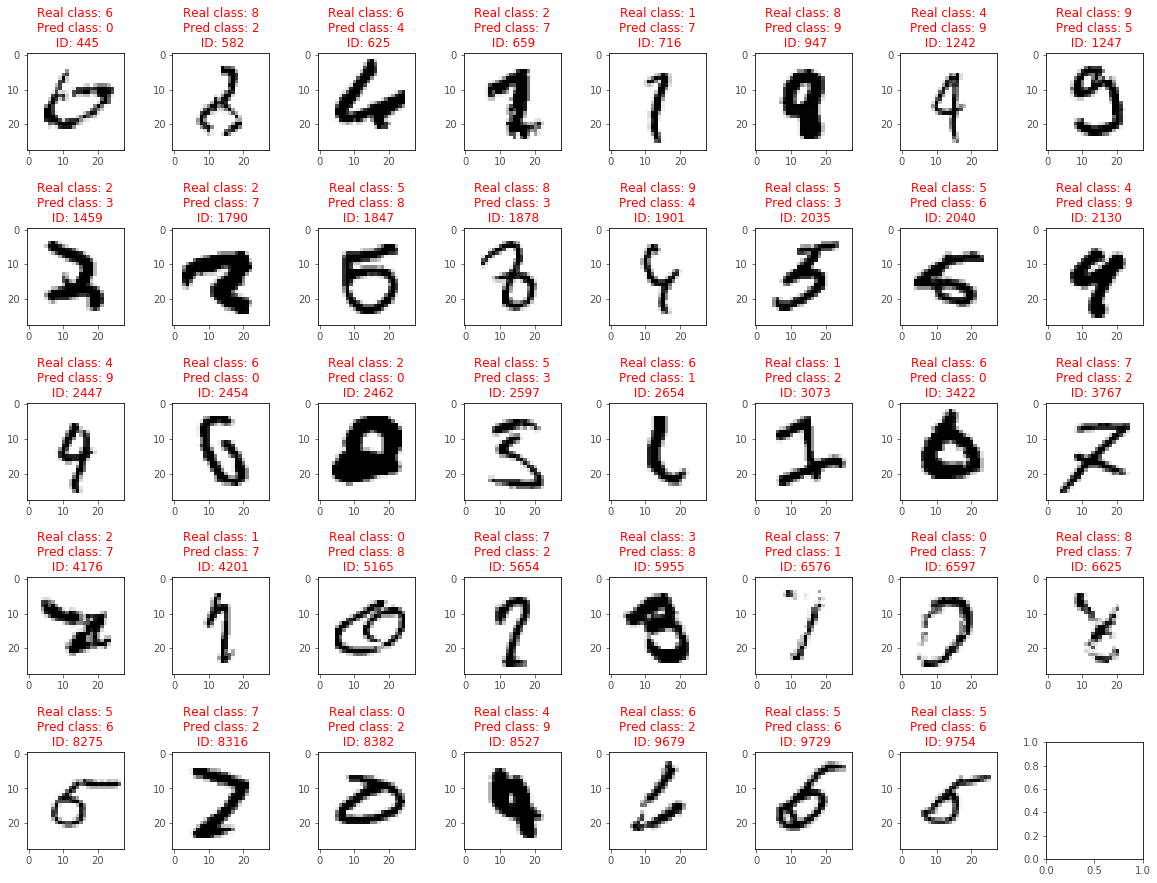

In [61]:
%matplotlib inline

# real labels
set_y_real = y_real[error_indices_cnn_merge]
set_y_pred = y_pred[error_indices_cnn_merge]

# style
rcParams['xtick.color'] = "#505050"     # ticks gray color
rcParams['ytick.color'] = "#505050"     # ticks gray color

# create plot
fig, axes = plt.subplots(5, 8, figsize=(20, 15))  #12, 5

for ix, yreal, ypred, ax in zip(error_indices_cnn_merge, set_y_real, set_y_pred, axes.flat):
    
    sample_image = test_images[ix]      # shape (28, 28)
    color = "k" 
    if yreal != ypred: color = "r"
    
    ax.set_title("Real class: %d\nPred class: %d\n ID: %d" % (yreal, ypred, ix), color=color)
    ax.imshow(sample_image, cmap=plt.cm.binary)

# adjust margins
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.savefig("numbers_incorrect_predictions_merge.jpg", dpi=300)

# Conclusions

In this notebook, we discuss how to design a neural network for digit classification. We trained several models and achieved an accuracy of 99.6% in the test set. This means that only 39 of 10,000 images were incorrectly classified. 

```
Accuracy: 0.996100
# of misclassified images: 39
```

In order to achieved that result, we did the following:

- Preprocess the dataset:
    - Change the range from `[0, 255]` to `[0, 1]`.
    - Change the data type from `int` to `float`.
    - Change the shape from `(28,28)` to `(28*28,)` for the first model, and `(28,28,1)` for the convolutional models.
    
- Split the dataset into training, validation, and test set.

- Increase the number of training examples by using data augmentation.

- Try several arquitectures:

    - v1: feed forward neural network
    - v2: convolutional neural network
    - v3: convolutional neural network + data augmentation
    - v4: convolutional neural network + data augmentation + dropout
    - v5: convolutional neural network + data augmentation + batch normalization
    - v4 + v5
    
The performance of the last two models is similar in terms of accuracy. However, the images classified incorrectly by these models are different. Hence, we combined both models to improve the accuracy. This notebook is available [here](https://gitlab.com/auraham/deep_learning_for_computer_vision/-/blob/master/notebooks/nb_cnn_mnist.ipynb).

## References

- [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python)
- [Notebook from Kaggle](https://www.kaggle.com/elcaiseri/mnist-simple-cnn-keras-accuracy-0-99-top-1)